# Huấn luyện mô hình CNN dùng phương pháp Transfer Learning cho tập MNIST FASHION

Transfer learning là một kỹ thuật học máy sử dụng kiến thức thu được từ một tác vụ (tác vụ nguồn) để giải quyết một tác vụ khác nhưng tương tự (tác vụ đích).

Trong transfer learning, chúng ta sẽ sử dụng một mô hình đã được đào tạo trước trên một tập dữ liệu lớn cho tác vụ nguồn. Sau đó, chúng ta sẽ tinh chỉnh mô hình này cho tác vụ đích bằng cách chỉ đào tạo các lớp trên cùng của mô hình. (Ở đây sẽ dùng ResNet50)

## Tạo tập huấn luyện và sinh thêm dữ liệu (data augment)

Sinh data theo các phương pháp:
* RandomFlip
* RandomRotation
* Shifting
* Zoom

Vì yêu cầu đầu vào của ResNet50 cần có channel=3 (chiều thứ 3 của 1 hình ảnh r,g,b nhưng hình ảnh của MNIST Fashion chỉ là hình ảnh gray_scale nên tiến hành tạo thêm 3 lớp)

In [2]:
#Khai báo các thư viện và hàm
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import savefig
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import MaxPooling2D, AveragePooling2D
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_process = X/255
        return X_process.reshape(X.shape[0], 28, 28, 1)
processor = Pipeline([
    ('Process', Preprocessor())
])
def expand_gray_scale(X):
    X_3_channel = X.repeat(3, axis=-1) #expand to 3 dimension
    return X_3_channel

In [3]:

#Load data
fashion_set = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_set

#Split Data from train set to train and cross set
X_train_, X_cross_, y_train_,  y_cross = train_test_split(X_train, y_train, random_state=42, train_size=0.8, stratify=y_train)
X_train_process = processor.fit_transform(X_train_)
X_cross_process = processor.transform(X_cross_)

#Create more data
data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='nearest', cval=0)

data_generator.fit(X_train_process)
batch = data_generator.flow(X_train_process, y_train_, seed=42, batch_size=128)
batch.image_data_generator
X_batch, y_batch = data_generator.flow(X_train_process, y_train_, batch_size=10, shuffle=False).next()
X_augment, y_augment = data_generator.flow(X_train_process, y_train_, batch_size=X_train_process.size).next()
X_augment_train = np.concatenate((X_augment, X_train_process), axis=0)
y_augment_train = np.concatenate((y_augment, y_train_), axis=0)
print(y_augment_train.shape)

#Shuffle
shuffle_indices = np.random.permutation(X_augment_train.shape[0])
X_augment_train = X_augment_train[shuffle_indices]
y_augment_train = y_augment_train[shuffle_indices]

#Expand channel
X_augment_train_3 = expand_gray_scale(X_augment_train)
X_cross_3 = expand_gray_scale(X_cross_process)
X_test_process = processor.transform(X_test)
X_test_3 = expand_gray_scale(X_test_process)

(96000,)


## Transfer learning thuần

### Xây dựng mô hình 

Vì trong mô hình Resnet50 đã tồn tại 50 tầng học sâu gồm các tầng tích chập và pooling 
nên ta chỉ cần thêm tầng kết nối đầy đủ và tầng cuối cùng với số nơ ron là 10 để phân loại.

Ở đây việc khai thác huấn luyện từ lớp thứ 150 của Resnet50 nhằm:
+ Khai thác được các đặc trưng phức tạp của dữ liệu
+ Giảm sự phụ thuộc của bộ dữ liệu đào tạo trước

In [ ]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False,pooling='avg', weights='imagenet'))

transfer_model.add(Dense(512,activation='relu'))
transfer_model.add(Dense(10, activation='linear'))

transfer_model.layers[0].trainable=True #Huấn luyện từ lớp 150 trở đi của resnet50 (176 lớp)
for layer in transfer_model.layers[0].layers[:150]:
    layer.trainable=False
transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 11044362 (42.13 MB)
Non-trainable params: 13597568 (51.87 MB)
_________________________________________________________________


In [ ]:
folder=r'/model_training/transfer_model/'
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'transfer_model_CNN_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
print(X_augment_train_3.shape)
transfer_model.fit(X_augment_train_3, y_augment_train,epochs=50,verbose=1, batch_size=32,validation_data=(X_cross_3, y_cross), callbacks=[checkpoint])

(96000, 28, 28, 3)
Epoch 1/50
2998/3000 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.7484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 61s 20ms/step - loss: 0.6857 - accuracy: 0.7484 - val_loss: 0.5522 - val_accuracy: 0.7927
Epoch 2/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.5454 - accuracy: 0.7925 - val_loss: 0.5894 - val_accuracy: 0.7811
Epoch 3/50
3000/3000 [==============================] - 61s 20ms/step - loss: 0.4987 - accuracy: 0.8084 - val_loss: 0.5156 - val_accuracy: 0.8154
Epoch 4/50
3000/3000 [==============================] - 57s 19ms/step - loss: 0.4625 - accuracy: 0.8227 - val_loss: 0.5223 - val_accuracy: 0.8098
Epoch 5/50
3000/3000 [==============================] - 57s 19ms/step - loss: 0.4349 - accuracy: 0.8330 - val_loss: 0.4331 - val_accuracy: 0.8430
Epoch 6/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.4144 - accuracy: 0.8394 - val_loss: 0.4346 - val_accuracy: 0.8394
Epoch 7/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.3978 - accuracy: 0.8462 - val_loss: 0.4954 - val_accura

In [ ]:
model_history = pd.DataFrame(transfer_model.history.history)
model_history

,loss,accuracy,val_loss,val_accuracy
0,0.685692,0.748417,0.552223,0.792667
1,0.545434,0.792479,0.589386,0.781083
2,0.498714,0.808375,0.515615,0.815417
3,0.462538,0.822719,0.522330,0.809750
4,0.434887,0.833042,0.433128,0.843000
5,0.414370,0.839365,0.434613,0.839417
6,0.397841,0.846229,0.495386,0.827417
7,0.378660,0.854479,0.430340,0.848750
8,0.362574,0.859250,0.409251,0.860167
9,0.351111,0.864177,0.452892,0.849083


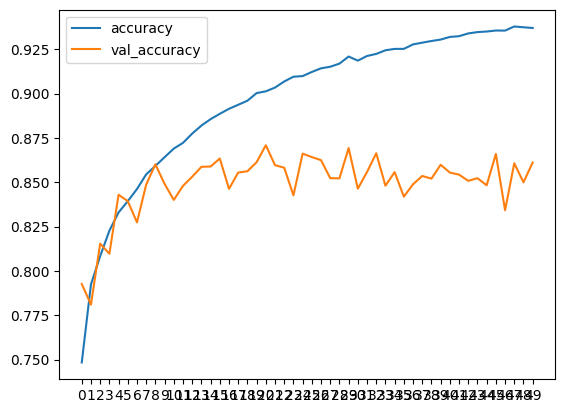

In [ ]:
model_history.loc[:,['accuracy','val_accuracy']].plot()
k=plt.xticks(model_history.index)
savefig('acc_vs_val_acc_before_tuning_transfer_model.png')

### Nhận xét

Về sau mô hình xuất hiện hiện tượng high varience, chênh lệch giữa accuracy của tập train và accuracy của tập cross càng lớn.

=> Overfitting

=> Mô hình cơ thể bị phụ thuộc vào một số đặc trưng, chi tiết nhiễu của tập dữ liệu

=> Khả năng khái quát hóa của mô hình kém

## Transfer learning với tuning


Để giảm hiện tượng trên, dùng kĩ thuật regularization như: regularization L2 hay dropout

Regularization: Ngăn chặn các trọng số quá lớn hoặc quá nhỏ, giúp loại bỏ các đặc trưng không cần thiết 

Dropout: Giảm sự phụ thuộc giữa các nơ-ron và tăng tính đa dạng mô hình, do mô hình không học được nhiều biểu diễn độc lập của dữ liệu

### Xây dựng mô hình CNN với transfer learning có sử dụng kĩ thuật regularization

In [3]:
def create_transfer_tuning_model():
    transfer_model = Sequential()
    transfer_model.add(ResNet50(include_top=False,pooling='avg', weights='imagenet'))
    transfer_model.layers[0].trainable=True #Huấn luyện từ lớp 150 trở đi của resnet50
    for layer in transfer_model.layers[0].layers[:150]:
        layer.trainable=False
    transfer_model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    transfer_model.add(Dense(128,activation='softmax',kernel_regularizer=regularizers.l2(0.001)))
    transfer_model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    transfer_model.add(Dropout(rate=0.2))
    transfer_model.add(Dense(10, activation='linear'))

    learning_rate = 0.0001
    transfer_model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))
    return transfer_model

In [6]:
folder=r'/model_training/transfer_model_tuning/'
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'transfer_tuning_model_CNN_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto',patience=5)

In [5]:
transfer_tuning_model=create_transfer_tuning_model()
transfer_tuning_model.fit(X_augment_train_3, y_augment_train,epochs=50,verbose=1, batch_size=32,validation_data=(X_cross_3, y_cross), callbacks=[checkpoint])

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/50
2999/3000 [============================>.] - ETA: 0s - loss: 1.5309 - accuracy: 0.6196

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 77s 19ms/step - loss: 1.5307 - accuracy: 0.6197 - val_loss: 0.9015 - val_accuracy: 0.7134
Epoch 2/50
3000/3000 [==============================] - 59s 20ms/step - loss: 0.8329 - accuracy: 0.7062 - val_loss: 0.6725 - val_accuracy: 0.7486
Epoch 3/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.7257 - accuracy: 0.7336 - val_loss: 0.6917 - val_accuracy: 0.7426
Epoch 4/50
3000/3000 [==============================] - 57s 19ms/step - loss: 0.6761 - accuracy: 0.7547 - val_loss: 0.5976 - val_accuracy: 0.8120
Epoch 5/50
3000/3000 [==============================] - 58s 19ms/step - loss: 0.6384 - accuracy: 0.7787 - val_loss: 0.5814 - val_accuracy: 0.8230
Epoch 6/50
3000/3000 [==============================] - 56s 19ms/step - loss: 0.6015 - accuracy: 0.8046 - val_loss: 0.5502 - val_accuracy: 0.8290
Epoch 7/50
3000/3000 [==============================] - 59s 20ms/step - loss: 0.5742 - accuracy: 0.8159 - val_loss: 0.5181 - val_accura

In [6]:
model_history = pd.DataFrame(transfer_tuning_model.history.history)
model_history

,loss,accuracy,val_loss,val_accuracy
0,1.530739,0.619677,0.901496,0.713417
1,0.832875,0.706156,0.672533,0.748583
2,0.725706,0.733594,0.691717,0.742583
3,0.676085,0.754677,0.597592,0.812000
4,0.638396,0.778698,0.581434,0.823000
5,0.601478,0.804563,0.550210,0.829000
6,0.574222,0.815896,0.518110,0.844250
7,0.549089,0.825896,0.514124,0.845083
8,0.528976,0.832792,0.495547,0.849667
9,0.514808,0.836698,0.521842,0.834750


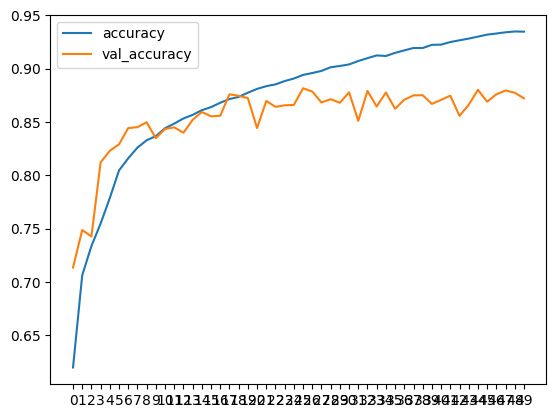

In [7]:
model_history.loc[:,['accuracy','val_accuracy']].plot()
k=plt.xticks(model_history.index)
savefig('acc_vs_val_acc_after_tuning_transfer_model.png')

In [ ]:
y_pred_reg = np.argmax(transfer_tuning_model.predict(X_test_3), axis=1)

313/313 [==============================] - 4s 10ms/step


In [ ]:
accuracy_score(y_test, y_pred_reg)

0.8692

### Nhận xét


Mô hình đã cải thiện đáng kể hiện tượng varience và sự chênh lệch không quá lớn so với trước khi tuning

=> Cải thiện phần nào khả năng khái quát của mô hình

=> Mô hình ít phụ thuộc vào vài chi tiết nhiễu của tập huấn luyện



### Test trên toàn bộ model transfer trước và sau tuning

In [1]:

from load_best_model import evaluate_folder_model
model_dir=r'D:\PythonWorkspace\PythonMain\MNIST_MAIN\model_training\transfer_model_before&after'
print(evaluate_folder_model(model_dir))

Found file: transfer_model_CNN_epoch_01_val_acc_0.79.h5
313/313 [==============================] - 41s 126ms/step
accuracy: 0.7798
Found file: transfer_model_CNN_epoch_03_val_acc_0.82.h5
313/313 [==============================] - 43s 134ms/step
accuracy: 0.806
Found file: transfer_model_CNN_epoch_05_val_acc_0.84.h5
313/313 [==============================] - 40s 125ms/step
accuracy: 0.8417
Found file: transfer_model_CNN_epoch_08_val_acc_0.85.h5
313/313 [==============================] - 42s 131ms/step
accuracy: 0.8405
Found file: transfer_model_CNN_epoch_09_val_acc_0.86.h5
313/313 [==============================] - 44s 135ms/step
accuracy: 0.8543
Found file: transfer_model_CNN_epoch_16_val_acc_0.86.h5
313/313 [==============================] - 45s 136ms/step
accuracy: 0.8561
Found file: transfer_model_CNN_epoch_21_val_acc_0.87.h5
313/313 [==============================] - 47s 147ms/step
accuracy: 0.8647
Found file: transfer_tuning_model_CNN_epoch_01_val_acc_0.71.h5
313/313 [============

Kết quả cho thấy model được huấn luyện bởi transfer sau tuning cho kết quả dự đoán tập test tốt hơn